In [15]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

import trim_duplicates, model, network, gradcam, plots
from dataset import Dataset
import jax.numpy as jnp
import numpy as np
import jax
import sklearn
import wandb
from trim_duplicates import DuplicatesData
import matplotlib.pyplot as plt

assert jax.local_device_count() >= 8
#jax.config.update('jax_platform_name', 'cpu')

NUM_CLASSES = 4
SEED = 14
BATCH_SIZE = 128

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
rng = jax.random.split(jax.random.PRNGKey(1))[0]
ds = Dataset.load("tawsifur", rng=rng)

tcmalloc: large alloc 16644833280 bytes == 0x62dafa000 @  0x7fdca28e2680 0x7fdca2903824 0x7fdc97f794ce 0x7fdc97fcf00e 0x7fdc97fcfc4f 0x7fdc98071924 0x5f2fb9 0x5f3446 0x56fb02 0x56822a 0x5f6033 0x56b115 0x56822a 0x5f6033 0x56ef97 0x56822a 0x5f6033 0x56b115 0x56822a 0x68c1e7 0x5ff1f4 0x5c3cb0 0x569f5e 0x5002e8 0x56b95e 0x5002e8 0x56b95e 0x5002e8 0x503f46 0x56a136 0x5f5e56
tcmalloc: large alloc 16644833280 bytes == 0xa0f414000 @  0x7fdca28e2680 0x7fdca2903824 0x7fdca2903b8a 0x7fd9cf60837c 0x7fd9cb09c520 0x7fd9cb0ac228 0x7fd9cb0afaac 0x7fd9cafecfb2 0x7fd9cadc4c88 0x7fd9cadac991 0x5f2fb9 0x5f3446 0x50aa8b 0x56ef97 0x56822a 0x5f6033 0x5f5869 0x664d7d 0x5f2c0e 0x56b7b0 0x56822a 0x5f6033 0x5f2b87 0x56b7b0 0x56822a 0x5f6033 0x5f5869 0x664d7d 0x5f2c0e 0x56b7b0 0x5f5e56
tcmalloc: large alloc 13315866624 bytes == 0x637228000 @  0x7fdca28e2680 0x7fdca2903824 0x7fdca2903b8a 0x7fd9cf60837c 0x7fd9cb09c520 0x7fd9cb0ac228 0x7fd9cb0afaac 0x7fd9cafecfb2 0x7fd9cadc4c88 0x7fd9cadac991 0x5f2fb9 0x5f3446 0x50

In [17]:
from functools import partial

@partial(jax.vmap, in_axes = (None, 0))
@partial(jax.vmap, in_axes = (0, None))
def cosine_similarity(x,y):
    return jnp.dot(x,y) / jnp.sqrt(jnp.dot(x,x) * jnp.dot(y,y))

embeddings = ds.x_all.reshape(ds.x_all.shape[0], -1)

sims = cosine_similarity(embeddings, embeddings)
sims = sims - np.eye(sims.shape[0])

tcmalloc: large alloc 16644833280 bytes == 0xa0f414000 @  0x7fdca28e2680 0x7fdca2903824 0x7fdca2903b8a 0x7fd9cf60837c 0x7fd9cb09c520 0x7fd9cb0ac228 0x7fd9cb0afaac 0x7fd9cafecfb2 0x7fd9cadc4c88 0x7fd9cadac991 0x5f2fb9 0x5f3446 0x50aa8b 0x56ef97 0x56822a 0x5f6033 0x5f5869 0x664d7d 0x5f2c0e 0x56b7b0 0x56822a 0x5f6033 0x5f2b87 0x56b7b0 0x56822a 0x5f6033 0x5f5869 0x664d7d 0x5f2c0e 0x56b7b0 0x5f5e56


In [18]:
y_all = ds.y_all.argmax(axis=1)
D = np.tile(y_all, (y_all.shape[0], 1))

In [19]:
D

array([[1, 0, 3, ..., 3, 1, 2],
       [1, 0, 3, ..., 3, 1, 2],
       [1, 0, 3, ..., 3, 1, 2],
       ...,
       [1, 0, 3, ..., 3, 1, 2],
       [1, 0, 3, ..., 3, 1, 2],
       [1, 0, 3, ..., 3, 1, 2]], dtype=int32)

In [20]:
diff = D != D.T
sims_diff = jnp.multiply(sims, diff)

<AxesSubplot:ylabel='Count'>

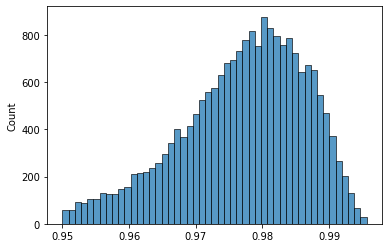

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

max_sims = sims_diff.max(axis=0)
sns.histplot(max_sims[max_sims > 0.95])